In [1]:
import time
import torch
from torch import nn
import numpy as np
from matplotlib import pyplot as plt
import nbimporter
from OptiEngine import FEM_2D, Config, Timer, optimize

In [2]:
class Timer():
    def __init__(self):
        pass
    
    def start(self):
        self.start_time = time.time()
        
    def end_print(self, print_row):
        end_time = time.time()
        time_passed = round(end_time - self.start_time, 4)
        
        print(f'{print_row} {time_passed} sec')
        
    def time_passed(self):
        end_time = time.time()
        time_passed = round(end_time - self.start_time, 8)
        
        return time_passed

In [3]:
def load_data(path, name_pattern, n_samples):
    pattern = f'{path}\\{name_pattern}_'
    fiter_pattern = f'{path}\\{name_pattern}_first_iter_'
    
    # Loading first sample
    samples = np.loadtxt(f'{pattern}{0}_result.txt')
    f_iters = np.loadtxt(f'{fiter_pattern}{0}_result.txt')
    
    for sample_i in range(1, n_samples):
        new_sample = np.loadtxt(f'{pattern}{sample_i}_result.txt')
        new_fiter = np.loadtxt(f'{fiter_pattern}{sample_i}_result.txt')
        samples = np.concatenate([samples, new_sample], axis = 0)
        f_iters = np.concatenate([f_iters, new_fiter], axis = 0)
        
    return (samples.reshape(n_samples, 29, 29), f_iters.reshape(n_samples, 29, 29))

In [4]:
def shuffle_data(samples, tasks):
    random_index = np.random.randint(0, samples.shape[0], size = samples.shape[0])
    
    samples_shuffled = samples[random_index]
    tasks_shuffled = tasks[random_index]
    
    return (samples_shuffled, tasks_shuffled)

def binarize_data(samples, threshold):
    for i in range(samples.shape[0]):
        for row in range(29):
            for col in range(29):
                samples[i][row][col] = 0.0 if samples[i][row][col] < threshold else 1.0
    return samples

In [5]:
def gen_batches(samples, f_iters, batch_size):
    batches = []
    n_samples = samples.shape[0]
    n_batches = int((n_samples-1) / batch_size)
    
    samples_shuffled, f_iters_shuffled = shuffle_data(samples, f_iters)
    
    for i in range(n_batches):
        batch_samp = samples_shuffled[i*batch_size]
        batch_fiter = f_iters_shuffled[i*batch_size]
        
        for j in range(1, batch_size):
            batch_samp = np.concatenate((batch_samp, samples_shuffled[i*batch_size + j]), axis = 0)
            batch_fiter = np.concatenate((batch_fiter, f_iters_shuffled[i*batch_size + j]), axis = 0)
        
        batch_samp = batch_samp.reshape(batch_size, 29, 29)
        batch_fiter = batch_fiter.reshape(batch_size, 29, 29)
            
        batches.append((batch_samp, batch_fiter))
    return batches

In [6]:
class TopologyGenerator_FirstIter(nn.Module):
    def __init__(self):
        super().__init__()
        
        # INPUT: 29 x 29 x 1
        # ENCODER
        self.conv_1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 2, padding = 0)   # 28 x 28 x 32
        self.conv_2 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1) # 28 x 28 x 32
        
        self.pool_1 = nn.MaxPool2d(kernel_size = 2)                                                 # 14 x 14 x 32
        self.bnorm_1 = nn.BatchNorm2d(32)
        
        self.conv_3 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1)  # 14 x 14 x 32
        self.conv_4 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1)  # 14 x 14 x 32
        
        self.pool_2 = nn.MaxPool2d(kernel_size = 2)
        self.bnorm_2 = nn.BatchNorm2d(32)
        
        self.conv_5 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1) # 7 x 7 x 32
        self.conv_6 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1) # 7 x 7 x 32
        
        # DECODER
        self.upsample_1 = nn.Upsample(scale_factor = 2)                                              # 14 x 14 x 32
       
        self.upconv_1 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1) # 14 x 14 x 32
        self.upconv_2 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1) # 14 x 14 x 32
        
        self.upsample_2 = nn.Upsample(scale_factor = 2)                                              # 28 x 28 x 32
        
        self.upconv_3 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1) # 28 x 28 x 32
        self.upconv_4 = nn.ConvTranspose2d(in_channels = 32, out_channels = 16, kernel_size = 2, padding = 0) # 29 x 29 x 16
        
        self.final_upconv = nn.Conv2d(in_channels = 16, out_channels = 1, kernel_size = 3, padding = 1) # 29 x 29 x 1
        
        self.activ = nn.LeakyReLU(0.2)
    
    def forward(self, x):
        x = self.conv_1(x)
        x = self.activ(x)
        x = self.conv_2(x)
        x = self.activ(x)
        
        x = self.pool_1(x)
        x = self.bnorm_1(x)
        
        x = self.conv_3(x)
        x = self.activ(x)
        x = self.conv_4(x)
        x = self.activ(x)
        
        x = self.pool_2(x)
        x = self.bnorm_2(x)
        
        x = self.conv_5(x)
        x = self.activ(x)
        x = self.conv_6(x)
        x = self.activ(x)
        
        x = self.upsample_1(x)
        
        x = self.upconv_1(x)
        x = self.activ(x)
        x = self.upconv_2(x)
        x = self.activ(x)
        
        x = self.upsample_2(x)
        
        x = self.upconv_3(x)
        x = self.activ(x)
        x = self.upconv_4(x)
        x = self.activ(x)
        x = self.final_upconv(x)
        
        return x

In [7]:
def train(model, n_epochs, learning_rate, origin_samples, origin_fiters, batch_size):
    optimizer = torch.optim.Adam(model.parameters(), learning_rate)
    loss_func = nn.MSELoss()
    
    for epoch in range(n_epochs):
        print(f'Epoch {epoch + 1}. Lr = {learning_rate}')
        for batch in gen_batches(origin_samples, origin_fiters, batch_size):
            samples, f_iters = batch
            
            samples = torch.FloatTensor(samples).reshape(-1, 1, 29, 29)
            f_iters = torch.FloatTensor(f_iters).reshape(-1, 1, 29, 29)
            
            predict = model(f_iters)
            loss = loss_func(predict, samples)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [8]:
path = 'C:\\Users\\mihai\\Desktop\\Unik\\4 курс\\Оптимизация\\Train_Data\\Square_Bucket_1'
name_pattern = 'bucket1'
n_samples = 2640

In [9]:
samples, f_iters = load_data(path, name_pattern, n_samples)

Sample first iteration: 


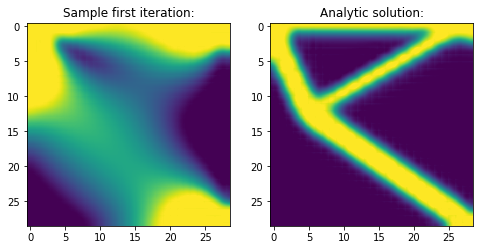

In [11]:
fig, axes = plt.subplots(1, 2, figsize = (8,8))

axes[0].imshow(f_iters[0], interpolation = 'bessel')
axes[0].set_title('Sample first iteration:')
axes[1].imshow(samples[0], interpolation = 'bessel')
axes[1].set_title('Analytic solution:')
print('Sample first iteration: ')

In [12]:
model = TopologyGenerator_FirstIter()

In [13]:
train(model, 40, 1e-3, samples, f_iters, 32)

Epoch 1. Lr = 0.001
Epoch 2. Lr = 0.001
Epoch 3. Lr = 0.001
Epoch 4. Lr = 0.001
Epoch 5. Lr = 0.001
Epoch 6. Lr = 0.001
Epoch 7. Lr = 0.001
Epoch 8. Lr = 0.001
Epoch 9. Lr = 0.001
Epoch 10. Lr = 0.001
Epoch 11. Lr = 0.001
Epoch 12. Lr = 0.001
Epoch 13. Lr = 0.001
Epoch 14. Lr = 0.001
Epoch 15. Lr = 0.001
Epoch 16. Lr = 0.001
Epoch 17. Lr = 0.001
Epoch 18. Lr = 0.001
Epoch 19. Lr = 0.001
Epoch 20. Lr = 0.001
Epoch 21. Lr = 0.001
Epoch 22. Lr = 0.001
Epoch 23. Lr = 0.001
Epoch 24. Lr = 0.001
Epoch 25. Lr = 0.001
Epoch 26. Lr = 0.001
Epoch 27. Lr = 0.001
Epoch 28. Lr = 0.001
Epoch 29. Lr = 0.001
Epoch 30. Lr = 0.001
Epoch 31. Lr = 0.001
Epoch 32. Lr = 0.001
Epoch 33. Lr = 0.001
Epoch 34. Lr = 0.001
Epoch 35. Lr = 0.001
Epoch 36. Lr = 0.001
Epoch 37. Lr = 0.001
Epoch 38. Lr = 0.001
Epoch 39. Lr = 0.001
Epoch 40. Lr = 0.001


Simp solution taken: 6.4675 sec
NN design taken: 0.1564 sec


Text(0.5, 1.0, 'NN Design')

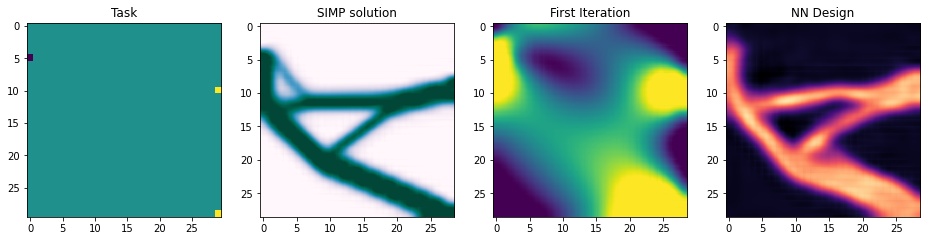

In [18]:
custom_task = np.zeros((30, 30))
custom_task[5][0] = -1
custom_task[10][29] = 1
custom_task[29][29] = 1

config = Config()

nx = 30
ny = 30

config.nx = nx
config.ny = ny

config.vol_frac = 0.3
config.penalize = 3

config.dense_delta = 0.01
config.max_iter = 40

config.E0 = 1
config.E_void = 1e-9

config.filter_r = 1.5
config.move = 0.2

config.fem_save_iters = [1]

FEM_solver = FEM_2D(config.nx, config.ny, config.filter_r)

FEM_solver.fix_node(10, 29, True, True)
FEM_solver.fix_node(29, 29, True, True)
FEM_solver.apply_load(5, 0, 0, -1)

timer = Timer()
FEM_solver.form_elements()
config.H, config.sH = FEM_solver.prepare_filter()
timer.start()
xPhys_opt = optimize(FEM_solver, config, False, False)

ey = ny - 1
ex = nx - 1

x_matrix = np.zeros((ey, ex))
for col in range(ex):
    for row in range(ey):
        x_matrix[row][col] = xPhys_opt[col*ey + row]
timer.end_print('Simp solution taken:')
        
fig, axes = plt.subplots(1, 4, figsize = (16, 16))

timer = Timer()

timer.start()
config.max_iter = 1
xPhys_opt_fi = optimize(FEM_solver, config, False, False)
x_matrix_fi = np.zeros((ey, ex))
for col in range(ex):
    for row in range(ey):
        x_matrix_fi[row][col] = xPhys_opt_fi[col*ey + row]

nn_design = model(torch.FloatTensor(x_matrix_fi).reshape(-1,1,29,29)).detach().reshape(29,29)
timer.end_print('NN design taken:')
        
axes[0].imshow(custom_task)
axes[0].set_title('Task')

axes[1].imshow(x_matrix, interpolation = 'bessel', cmap = 'PuBuGn')
axes[1].set_title('SIMP solution')

axes[2].imshow(x_matrix_fi, interpolation = 'bessel')
axes[2].set_title('First Iteration')

axes[3].imshow(nn_design, interpolation = 'bessel', cmap = 'magma')
axes[3].set_title('NN Design')

In [16]:
save_name = 'NeuralNetwork_FirstIter_params'
torch.save(model.state_dict(), save_name)